# 2.- Labeling

In [31]:
import os
import pandas as pd
import xml.etree.ElementTree as ET

import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

## XML to CSV

In [32]:
input_path = '../data/raw/airplane'

In [33]:
def get_xml_files(input_path):
    """
    Generate a list of XML file paths from the specified directory.

    Parameters:
    input_path (str): Path to the directory containing XML files.

    Returns:
    list: List of XML file paths.
    """
    return [os.path.join(input_path, file) for file in os.listdir(input_path) if file.endswith('.xml')]

In [34]:
get_xml_files(input_path)

['../data/raw/airplane\\airplane_001.xml',
 '../data/raw/airplane\\airplane_002.xml',
 '../data/raw/airplane\\airplane_003.xml',
 '../data/raw/airplane\\airplane_004.xml',
 '../data/raw/airplane\\airplane_005.xml',
 '../data/raw/airplane\\airplane_006.xml',
 '../data/raw/airplane\\airplane_007.xml',
 '../data/raw/airplane\\airplane_008.xml',
 '../data/raw/airplane\\airplane_009.xml',
 '../data/raw/airplane\\airplane_010.xml',
 '../data/raw/airplane\\airplane_011.xml',
 '../data/raw/airplane\\airplane_012.xml',
 '../data/raw/airplane\\airplane_013.xml',
 '../data/raw/airplane\\airplane_014.xml',
 '../data/raw/airplane\\airplane_015.xml',
 '../data/raw/airplane\\airplane_016.xml',
 '../data/raw/airplane\\airplane_017.xml',
 '../data/raw/airplane\\airplane_018.xml',
 '../data/raw/airplane\\airplane_019.xml',
 '../data/raw/airplane\\airplane_020.xml']

In [35]:
def xml_to_csv(input_path, output_csv=None):
    """
    Convert XML files in the given path to a single CSV file or DataFrame.

    Parameters:
    input_path (str): Path to the directory containing XML files.
    output_csv (str, optional): Path to save the output CSV file. If None, the function returns a DataFrame.

    Returns:
    pd.DataFrame: DataFrame containing the converted data (if output_csv is None).
    """
    xml_list = []
    for xml_file in get_xml_files(input_path):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        for member in root.findall('object'):
            value = (
                os.path.join('../data/raw/airplane/', root.find('filename').text),
                int(member.find('bndbox/xmin').text),
                int(member.find('bndbox/ymin').text),
                int(member.find('bndbox/xmax').text),
                int(member.find('bndbox/ymax').text),
                member.find('name').text
            )
            xml_list.append(value)

    column_names = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
    xml_df = pd.DataFrame(xml_list, columns=column_names)

    if output_csv:
        xml_df.to_csv(output_csv, index=False)
        print(f'CSV file saved at: {output_csv}')
    else:
        return xml_df

In [36]:
bounding_boxes_df = xml_to_csv(input_path, output_csv=None)
bounding_boxes_df

,filename,xmin,ymin,xmax,ymax,class
0,../data/raw/airplane/airplane_001.jpg,5,165,102,254,airplane
1,../data/raw/airplane/airplane_001.jpg,44,74,139,165,airplane
2,../data/raw/airplane/airplane_001.jpg,169,13,237,79,airplane
3,../data/raw/airplane/airplane_002.jpg,14,84,38,114,airplane
4,../data/raw/airplane/airplane_002.jpg,42,84,75,118,airplane
...,...,...,...,...,...,...
58,../data/raw/airplane/airplane_020.jpg,159,134,175,152,airplane
59,../data/raw/airplane/airplane_020.jpg,178,132,195,157,airplane
60,../data/raw/airplane/airplane_020.jpg,197,135,213,155,airplane
61,../data/raw/airplane/airplane_020.jpg,220,144,237,164,airplane


## Verify Bounding Boxes

In [37]:
def show_objects(image_row):
    """
    Display an image with bounding boxes drawn from a DataFrame row.

    Parameters:
    image_row (pd.Series): A row containing filename, xmin, ymin, xmax, ymax, and class.
    """
    img_path = image_row['filename']

    try:
        image = io.imread(img_path)
    except FileNotFoundError:
        print(f"Image file not found: {img_path}")
        return

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    rect = patches.Rectangle(
        (image_row['xmin'], image_row['ymin']),
        image_row['xmax'] - image_row['xmin'],
        image_row['ymax'] - image_row['ymin'],
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )

    ax.add_patch(rect)
    plt.axis('off')
    plt.show()

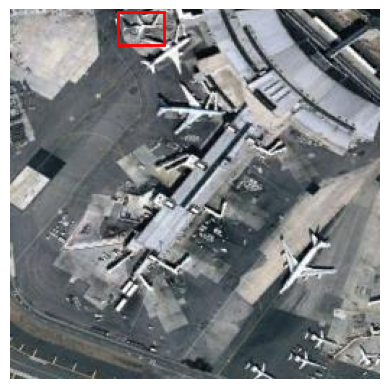

In [38]:
show_objects(bounding_boxes_df.iloc[17])

## Split and Save Labeled Data

In [43]:
def split_and_save_dataset(dataset_df,
                           train_csv='../data/labeled/annotations_train.csv',
                           test_csv='../data/labeled/annotations_test.csv',
                           classes_csv='../data/labeled/classes.csv',
                           test_size=0.2,
                           random_state=2):
    """
    Split the dataset into training and testing sets and save them to CSV files.

    Parameters:
    dataset_df (pd.DataFrame): The dataset to split.
    train_csv (str): Filename to save the training set.
    test_csv (str): Filename to save the test set.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Random seed for reproducibility.
    """
    train_df, test_df = train_test_split(dataset_df,
                                         test_size=test_size,
                                         random_state=random_state)
    
    train_df.to_csv(train_csv, index=False, header=None)
    test_df.to_csv(test_csv, index=False, header=None)
    print(f'Training data saved to {train_csv}')
    print(f'Testing data saved to {test_csv}')

    classes = sorted(dataset_df['class'].unique())
    with open(classes_csv, 'w') as f:
        for i, line in enumerate(classes):
            f.write(f'{line},{i}\n')
    print('Class mapping saved to classes.csv')

In [44]:
split_and_save_dataset(bounding_boxes_df)

Training data saved to ../data/labeled/annotations_train.csv
Testing data saved to ../data/labeled/annotations_test.csv
Class mapping saved to classes.csv
